In [1]:
import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt


import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import numpy as np
import tempfile
import h5py as h5
import glob
import os
from importlib import reload
import tqdm
import pickle
%matplotlib inline


import datetime
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/brad/DailyLog/20180802/


In [4]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

bird = 'B1083'
block_path = bps[bird]

# Parameters for binning
winsize = 10.0               # binning window size in milliseconds
dtovr = winsize*0.5          # window overlap in milliseconds
comment = 'ForSCM'         # We're plotting betti curves
segment_info = [0,0]       # We want the whole stimulus and just the stimulus

# Parameters for Betti curve computation
thresh = 13.0                            # Activation threshold
nperms = None                            # No permutations of the population - use full pop
ncellsperm = 20                          # Number of cells to subsample for each permuation
dims = [0,1,2,3,4]                        # Compute first five betti numbers
Ntimes = 1000                            # Number of interpolation points
stimlen = 6000                           # Stimulus length in milliseconds
twin = np.linspace(0, stimlen, Ntimes)   # Vector of interpolation time points


In [5]:
# Bin the data from each bird
bdfs = {}
for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20170829T191155Z-10.0-5.0.binned
/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20180612T185704Z-10.0-5.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20180612T220619Z-10.0-5.0.binned
/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSCM/20180612T222949Z-10.0-5.0.binned


In [6]:
reload(tp2)
bc_tavg_store = {}
t_store = {}
tms_store = {}
bc_tavg_shuff_store = {}

for bird in birds:
    bdf = bdfs[bird]
    block_path = bps[bird]
    # compute real and shuffled betti curves - TrialAverage
    print('Computing trial average')
    (bc_tavg, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr)
    (bc_tavg_shuff, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl-Shuffle', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr, shuffle=True)
    bc_tavg_store[bird] = bc_tavg
    bc_tavg_shuff_store[bird] = bc_tavg_shuff
    t_store[bird] = t
    tms_store[bird] = tms

Computing trial average
Computing trial average
Computing trial average
Computing trial average


In [5]:
# Compute SCM

reload(tp2)
bird_scm_dict = {}
for bird in birds:
    bdf = bdfs[bird]
    stim_dict = {}
    stim_shuffled_dict = {}
    stim_scm_dict = {}
    stim_betticurve_dict = {}
    stim_shuffled_betticurve_dict = {}
    with h5.File(bdf, 'r') as bdff:
        stims = bdff.keys()
        for stim in stims:
            print(stim)
            stim_poptens = tp2.extract_population_tensor(bdf, stim)
            ntrials = tp2.num_trials(stim_poptens)
            stim_scm_dat= []
            for trial in tqdm.tqdm(range(ntrials)):
                scm_bettis = tp2.calc_scm_betti_distribution(stim_poptens, thresh, trial, nsamples)

                stim_scm_dat.append(scm_bettis)
            stim_scm_dict[stim] = stim_scm_dat
    bird_scm_dict[bird] = stim_scm_dict

  0%|          | 0/20 [00:00<?, ?it/s]

A_scaled_burung
Extracting Population Activity Tensor...
Stim: A_scaled_burung, Clusters:None


NameError: name 'nsamples' is not defined

In [7]:
def plot_scm_distribution(scm_bettis, trial, bettinum, maxbin=200, ax=None, **kwargs):
    nmaxtot = 0
    scm_trial_bettis = scm_bettis[trial]
    bettivals = []
    try:
        for x in scm_trial_bettis:
            try:
                bettivals.append(x[0][bettinum])
            except IndexError:
                bettivals.append(0)
    except IndexError:
        bettivals = [x[bettinum] for x in scm_trial_bettis]
    bettivals2 = []
    for x in bettivals:
        if type(x) is not list:
            bettivals2.append(x)
        else:
            bettivals2.append(x[0])
    #print(bettivals)
    maxbettival = np.amax(bettivals2)
    maxbin = round(1.5*maxbettival)
    print(maxbin)
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettivals2, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

def plot_scm_distrib(scm_bettis, bettinum, maxbin=200, ax=None, **kwargs):
    
    nmaxtot = 0
    
    bettis = scm_bettis[:, 0, bettinum]
    bettis = bettis[bettis >=0]
    #print(bettis)
    maxbettival = np.amax(bettis)
    maxbin = round(1.5*(maxbettival+1))
    bins = np.arange(maxbin)
    (n, bins2, ptaches) = ax.hist(bettis, bins, normed=True, stacked=True, **kwargs)
    #print(n)
    nmax = np.amax(n)
    nmaxtot = np.amax([nmax, nmaxtot])
    nmaxx = np.amax(bins)
    return (nmaxtot, nmaxx)

In [8]:
# average over all trials
import tqdm
nsamples = 200
bird_scm_dict = {}
for bird in birds:
    bdf = bdfs[bird]
    stim_dict = {}
    stim_shuffled_dict = {}
    stim_scm_dict = {}
    stim_betticurve_dict = {}
    stim_shuffled_betticurve_dict = {}
    with h5.File(bdf, 'r') as bdff:
        stims = bdff.keys()
        for stim in tqdm.tqdm(stims):
            #print(stim)
            trial=0
            stim_poptens = tp2.extract_population_tensor(bdf, stim)
            ntrials = tp2.num_trials(stim_poptens)
            stim_scm_dat= []
            stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, :, np.newaxis]     
            scm_bettis = tp2.calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
            stim_scm_dict[stim] = scm_bettis
    bird_scm_dict[bird] = stim_scm_dict


  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



1it [13:03, 783.84s/it]
2it [13:04, 392.12s/it]
3it [13:04, 261.56s/it]
4it [13:05, 196.28s/it]
5it [13:05, 157.12s/it]
6it [13:05, 130.99s/it]
7it [13:06, 112.34s/it]
8it [13:06, 98.36s/it] 
9it [13:07, 87.48s/it]
10it [13:07, 78.77s/it]
11it [13:08, 71.65s/it]
12it [13:08, 65.71s/it]
13it [13:08, 60.69s/it]
14it [13:09, 56.39s/it]
15it [13:09, 52.65s/it]
16it [13:10, 49.39s/it]
17it [13:10, 46.51s/it]
18it [13:11, 43.95s/it]
19it [13:11, 41.66s/it]
20it [13:11, 39.59s/it]
21it [13:12, 37.73s/it]
22it [13:12, 36.03s/it]
23it [13:13, 34.48s/it]
24it [13:13, 33.06s/it]
25it [13:13, 31.76s/it]
26it [13:14, 30.55s/it]
27it [13:14, 29.44s/it]
28it [13:15, 28.40s/it]
29it [13:15, 27.44s/it]
30it [13:16, 26.54s/it]
31it [13:16, 25.69s/it]
32it [13:16, 24.90s/it]
33it [13:17, 24.16s/it]
34it [13:17, 23.46s/it]
35it [13:18, 22.80s/it]
36it [13:18, 22.18s/it]
37it [13:18, 21.59s/it]
38it [13:19, 21.04s/it]
39it [13:19, 20.51s/it]
40it [13:20, 20.01s/it]
41it [13:20, 19.53s/it]
42it [13:21, 19.

Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None



1it [09:07, 547.70s/it]
2it [09:07, 273.90s/it]
4it [09:07, 137.00s/it]
6it [09:08, 91.36s/it] 
8it [09:08, 68.55s/it]
10it [09:08, 54.85s/it]
12it [09:08, 45.73s/it]
14it [09:08, 39.21s/it]
16it [09:09, 34.32s/it]
18it [09:09, 30.52s/it]
20it [09:09, 27.47s/it]
22it [09:09, 24.98s/it]
24it [09:09, 22.91s/it]
26it [09:10, 21.15s/it]
28it [09:10, 19.65s/it]
30it [09:10, 18.35s/it]
32it [09:10, 17.21s/it]
34it [09:10, 16.20s/it]
36it [09:10, 15.30s/it]
38it [09:11, 14.50s/it]
40it [09:11, 13.78s/it]
42it [09:11, 13.13s/it]
44it [09:11, 12.54s/it]
46it [09:11, 12.00s/it]
48it [09:12, 11.50s/it]
50it [09:12, 11.04s/it]
52it [09:12, 10.62s/it]
54it [09:12, 10.23s/it]
56it [09:12,  9.87s/it]
58it [09:12,  9.53s/it]
60it [09:13,  9.22s/it]
62it [09:13,  8.93s/it]
64it [09:13,  8.65s/it]
66it [09:13,  8.39s/it]
68it [09:13,  8.15s/it]
70it [09:14,  7.92s/it]
72it [09:14,  7.70s/it]
74it [09:14,  7.49s/it]
76it [09:14,  7.30s/it]
78it [09:14,  7.11s/it]
80it [09:15,  6.94s/it]
82it [09:15,  6.

Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None



1it [09:24, 564.84s/it]
2it [09:25, 282.51s/it]
3it [09:25, 188.39s/it]
4it [09:25, 141.34s/it]
5it [09:25, 113.10s/it]
6it [09:25, 94.28s/it] 
7it [09:25, 80.84s/it]
8it [09:26, 70.76s/it]
9it [09:26, 62.91s/it]
10it [09:26, 56.64s/it]
11it [09:26, 51.50s/it]
12it [09:26, 47.23s/it]
13it [09:26, 43.61s/it]
14it [09:27, 40.50s/it]
15it [09:27, 37.82s/it]
16it [09:27, 35.46s/it]
17it [09:27, 33.39s/it]
18it [09:27, 31.54s/it]
19it [09:27, 29.89s/it]
20it [09:28, 28.41s/it]
21it [09:28, 27.06s/it]
22it [09:28, 25.84s/it]
23it [09:28, 24.72s/it]
24it [09:28, 23.70s/it]
25it [09:28, 22.76s/it]
26it [09:29, 21.89s/it]
27it [09:29, 21.09s/it]
28it [09:29, 20.34s/it]
29it [09:29, 19.64s/it]
30it [09:29, 18.99s/it]
31it [09:30, 18.39s/it]
32it [09:30, 17.82s/it]
33it [09:30, 17.28s/it]
34it [09:30, 16.78s/it]
35it [09:30, 16.30s/it]
36it [09:30, 15.86s/it]
37it [09:31, 15.43s/it]
38it [09:31, 15.03s/it]
39it [09:31, 14.65s/it]
40it [09:31, 14.29s/it]
41it [09:31, 13.95s/it]
42it [09:31, 13.62

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [04:22, 262.52s/it]
2it [04:22, 131.42s/it]
3it [04:23, 87.72s/it] 
4it [04:23, 65.87s/it]
5it [04:23, 52.76s/it]
6it [04:24, 44.02s/it]
7it [04:24, 37.77s/it]
8it [04:24, 33.09s/it]
9it [04:25, 29.45s/it]
10it [04:25, 26.53s/it]
11it [04:25, 24.15s/it]
12it [04:25, 22.17s/it]
13it [04:26, 20.48s/it]
14it [04:26, 19.04s/it]
15it [04:26, 17.79s/it]
16it [04:27, 16.70s/it]
17it [04:27, 15.74s/it]
18it [04:27, 14.88s/it]
19it [04:28, 14.11s/it]
20it [04:28, 13.42s/it]
21it [04:28, 12.80s/it]
22it [04:29, 12.23s/it]
23it [04:29, 11.71s/it]
24it [04:29, 11.24s/it]
25it [04:30, 10.80s/it]
26it [04:30, 10.40s/it]
27it [04:30, 10.02s/it]
28it [04:30,  9.68s/it]
29it [04:31,  9.35s/it]
30it [04:31,  9.05s/it]
31it [04:31,  8.77s/it]
32it [04:32,  8.50s/it]
33it [04:32,  8.26s/it]
34it [04:32,  8.02s/it]
35it [04:33,  7.80s/it]
36it [04:33,  7.59s/it]
37it [04:33,  7.40s/it]
38it [04:34,  7.21s/it]
39it [04:34,  7.03s/it]
40it [04:34,  6.87s/it]
41it [04:34,  6.71s/it]
42it [04:35,  6.55s/i

Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None



1it [11:55, 715.16s/it]
2it [11:55, 357.66s/it]
3it [11:55, 238.48s/it]
4it [11:55, 178.90s/it]
5it [11:55, 143.15s/it]
6it [11:55, 119.31s/it]
7it [11:56, 102.29s/it]
8it [11:56, 89.52s/it] 
9it [11:56, 79.59s/it]
10it [11:56, 71.65s/it]
11it [11:56, 65.15s/it]
12it [11:56, 59.73s/it]
13it [11:56, 55.15s/it]
14it [11:57, 51.22s/it]
15it [11:57, 47.81s/it]
16it [11:57, 44.83s/it]
17it [11:57, 42.20s/it]
18it [11:57, 39.86s/it]
19it [11:57, 37.77s/it]
20it [11:57, 35.89s/it]
21it [11:58, 34.19s/it]
22it [11:58, 32.64s/it]
23it [11:58, 31.23s/it]
24it [11:58, 29.94s/it]
25it [11:58, 28.74s/it]
26it [11:58, 27.64s/it]
27it [11:58, 26.62s/it]
28it [11:59, 25.68s/it]
29it [11:59, 24.80s/it]
30it [11:59, 23.98s/it]
31it [11:59, 23.21s/it]
32it [11:59, 22.49s/it]
33it [11:59, 21.81s/it]
34it [11:59, 21.17s/it]
35it [12:00, 20.57s/it]
36it [12:00, 20.01s/it]
37it [12:00, 19.47s/it]
38it [12:00, 18.96s/it]
39it [12:00, 18.48s/it]
40it [12:00, 18.02s/it]
41it [12:00, 17.58s/it]
42it [12:01, 17.

Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None



1it [12:22, 742.97s/it]
2it [12:23, 371.66s/it]
3it [12:23, 247.88s/it]
4it [12:24, 186.00s/it]
5it [12:24, 148.87s/it]
6it [12:24, 124.11s/it]
7it [12:24, 106.42s/it]
8it [12:25, 93.16s/it] 
9it [12:25, 82.85s/it]
10it [12:25, 74.59s/it]
11it [12:26, 67.84s/it]
12it [12:26, 62.22s/it]
13it [12:26, 57.45s/it]
14it [12:27, 53.37s/it]
15it [12:27, 49.83s/it]
16it [12:27, 46.74s/it]
17it [12:28, 44.01s/it]
18it [12:28, 41.58s/it]
19it [12:28, 39.42s/it]
20it [12:29, 37.46s/it]
21it [12:29, 35.70s/it]
22it [12:29, 34.09s/it]
23it [12:30, 32.62s/it]
24it [12:30, 31.27s/it]
25it [12:30, 30.03s/it]
26it [12:31, 28.89s/it]
27it [12:31, 27.84s/it]
28it [12:31, 26.85s/it]
29it [12:32, 25.94s/it]
30it [12:32, 25.09s/it]
31it [12:32, 24.29s/it]
32it [12:33, 23.54s/it]
33it [12:33, 22.84s/it]
34it [12:33, 22.18s/it]
35it [12:34, 21.55s/it]
36it [12:34, 20.96s/it]
37it [12:34, 20.40s/it]
38it [12:35, 19.88s/it]
39it [12:35, 19.38s/it]
40it [12:35, 18.90s/it]
41it [12:36, 18.45s/it]
42it [12:36, 18.

Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None



1it [05:49, 349.57s/it]
6it [05:49, 58.28s/it] 
11it [05:49, 31.80s/it]
15it [05:49, 23.33s/it]
20it [05:50, 17.50s/it]
25it [05:50, 14.01s/it]
29it [05:50, 12.08s/it]
34it [05:50, 10.31s/it]
38it [05:50,  9.22s/it]
43it [05:50,  8.15s/it]
47it [05:50,  7.46s/it]
52it [05:50,  6.75s/it]
57it [05:50,  6.16s/it]
62it [05:51,  5.66s/it]
67it [05:51,  5.24s/it]
72it [05:51,  4.88s/it]
77it [05:51,  4.56s/it]
82it [05:51,  4.29s/it]
87it [05:51,  4.04s/it]
92it [05:51,  3.82s/it]
97it [05:51,  3.63s/it]
102it [05:52,  3.45s/it]
107it [05:52,  3.29s/it]
112it [05:52,  3.15s/it]
117it [05:52,  3.01s/it]
122it [05:52,  2.89s/it]
127it [05:52,  2.78s/it]
132it [05:52,  2.67s/it]
137it [05:52,  2.58s/it]
142it [05:52,  2.49s/it]
147it [05:53,  2.40s/it]
152it [05:53,  2.32s/it]
157it [05:53,  2.25s/it]
162it [05:53,  2.18s/it]
167it [05:53,  2.12s/it]
172it [05:53,  2.06s/it]
177it [05:53,  2.00s/it]
182it [05:53,  1.94s/it]
187it [05:54,  1.89s/it]
192it [05:54,  1.84s/it]
197it [05:54,  1.80s

Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None



1it [06:21, 381.24s/it]
4it [06:21, 95.34s/it] 
7it [06:21, 54.49s/it]
10it [06:21, 38.16s/it]
13it [06:21, 29.36s/it]
16it [06:21, 23.86s/it]
19it [06:21, 20.10s/it]
22it [06:22, 17.36s/it]
25it [06:22, 15.28s/it]
28it [06:22, 13.65s/it]
31it [06:22, 12.33s/it]
34it [06:22, 11.25s/it]
37it [06:22, 10.34s/it]
40it [06:22,  9.57s/it]
43it [06:22,  8.90s/it]
46it [06:22,  8.32s/it]
49it [06:22,  7.82s/it]
52it [06:23,  7.37s/it]
55it [06:23,  6.97s/it]
58it [06:23,  6.61s/it]
61it [06:23,  6.29s/it]
64it [06:23,  5.99s/it]
67it [06:23,  5.73s/it]
70it [06:23,  5.48s/it]
73it [06:23,  5.26s/it]
76it [06:23,  5.05s/it]
79it [06:24,  4.86s/it]
82it [06:24,  4.69s/it]
85it [06:24,  4.52s/it]
88it [06:24,  4.37s/it]
91it [06:24,  4.23s/it]
94it [06:24,  4.09s/it]
97it [06:24,  3.97s/it]
100it [06:24,  3.85s/it]
103it [06:24,  3.74s/it]
106it [06:25,  3.63s/it]
109it [06:25,  3.53s/it]
112it [06:25,  3.44s/it]
115it [06:25,  3.35s/it]
118it [06:25,  3.27s/it]
121it [06:25,  3.19s/it]
124it [0

Extracting Population Activity Tensor...
Stim: A_scaled_burung, Clusters:None



1it [01:24, 84.93s/it]
7it [01:25, 12.15s/it]
13it [01:25,  6.55s/it]
19it [01:25,  4.49s/it]
25it [01:25,  3.42s/it]
30it [01:25,  2.85s/it]
36it [01:25,  2.38s/it]
41it [01:25,  2.09s/it]
47it [01:25,  1.83s/it]
53it [01:25,  1.62s/it]
59it [01:26,  1.46s/it]
65it [01:26,  1.33s/it]
71it [01:26,  1.22s/it]
77it [01:26,  1.12s/it]
83it [01:26,  1.04s/it]
89it [01:26,  1.03it/s]
95it [01:26,  1.10it/s]
101it [01:26,  1.16it/s]
107it [01:26,  1.23it/s]
113it [01:27,  1.30it/s]
119it [01:27,  1.36it/s]
125it [01:27,  1.43it/s]
131it [01:27,  1.50it/s]
137it [01:27,  1.56it/s]
143it [01:27,  1.63it/s]
149it [01:27,  1.70it/s]
155it [01:27,  1.76it/s]
161it [01:28,  1.83it/s]
167it [01:28,  1.90it/s]
173it [01:28,  1.96it/s]
179it [01:28,  2.03it/s]
185it [01:28,  2.09it/s]
191it [01:28,  2.16it/s]
197it [01:28,  2.22it/s]
  6%|▋         | 1/16 [01:28<22:11, 88.78s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: B_scaled_burung, Clusters:None



1it [00:49, 49.65s/it]
12it [00:49,  4.15s/it]
23it [00:49,  2.17s/it]
34it [00:49,  1.47s/it]
45it [00:50,  1.11s/it]
56it [00:50,  1.12it/s]
67it [00:50,  1.33it/s]
78it [00:50,  1.55it/s]
89it [00:50,  1.76it/s]
100it [00:50,  1.98it/s]
110it [00:50,  2.17it/s]
121it [00:50,  2.38it/s]
132it [00:50,  2.59it/s]
143it [00:51,  2.80it/s]
154it [00:51,  3.01it/s]
165it [00:51,  3.22it/s]
176it [00:51,  3.43it/s]
186it [00:51,  3.61it/s]
197it [00:51,  3.82it/s]
 12%|█▎        | 2/16 [02:20<16:22, 70.21s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: C_scaled_burung, Clusters:None



1it [00:59, 59.34s/it]
10it [00:59,  5.94s/it]
19it [00:59,  3.13s/it]
28it [00:59,  2.13s/it]
37it [00:59,  1.61s/it]
46it [00:59,  1.30s/it]
55it [00:59,  1.09s/it]
64it [01:00,  1.07it/s]
73it [01:00,  1.21it/s]
82it [01:00,  1.36it/s]
91it [01:00,  1.51it/s]
100it [01:00,  1.65it/s]
109it [01:00,  1.80it/s]
118it [01:00,  1.94it/s]
127it [01:00,  2.09it/s]
136it [01:00,  2.23it/s]
145it [01:01,  2.38it/s]
154it [01:01,  2.52it/s]
163it [01:01,  2.66it/s]
172it [01:01,  2.80it/s]
181it [01:01,  2.95it/s]
190it [01:01,  3.09it/s]
199it [01:01,  3.23it/s]
 19%|█▉        | 3/16 [03:22<14:35, 67.37s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: D_scaled_burung, Clusters:None



1it [00:20, 20.98s/it]
11it [00:21,  1.92s/it]
21it [00:21,  1.01s/it]
31it [00:21,  1.46it/s]
42it [00:21,  1.96it/s]
53it [00:21,  2.47it/s]
64it [00:21,  2.96it/s]
75it [00:21,  3.45it/s]
86it [00:21,  3.94it/s]
97it [00:21,  4.42it/s]
108it [00:22,  4.90it/s]
119it [00:22,  5.38it/s]
130it [00:22,  5.85it/s]
141it [00:22,  6.31it/s]
152it [00:22,  6.77it/s]
163it [00:22,  7.22it/s]
174it [00:22,  7.67it/s]
186it [00:22,  8.16it/s]
197it [00:22,  8.61it/s]
 25%|██▌       | 4/16 [03:45<11:15, 56.26s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: E_scaled_burung, Clusters:None



1it [01:04, 64.92s/it]
4it [01:05, 16.26s/it]
7it [01:05,  9.30s/it]
10it [01:05,  6.52s/it]
14it [01:05,  4.67s/it]
18it [01:05,  3.64s/it]
21it [01:05,  3.12s/it]
24it [01:05,  2.74s/it]
27it [01:05,  2.44s/it]
30it [01:05,  2.20s/it]
33it [01:05,  2.00s/it]
36it [01:06,  1.84s/it]
39it [01:06,  1.70s/it]
42it [01:06,  1.58s/it]
45it [01:06,  1.48s/it]
48it [01:06,  1.39s/it]
52it [01:06,  1.28s/it]
55it [01:06,  1.21s/it]
58it [01:06,  1.15s/it]
61it [01:06,  1.10s/it]
65it [01:07,  1.03s/it]
68it [01:07,  1.01it/s]
72it [01:07,  1.07it/s]
75it [01:07,  1.11it/s]
78it [01:07,  1.15it/s]
82it [01:07,  1.21it/s]
86it [01:07,  1.27it/s]
90it [01:07,  1.32it/s]
94it [01:08,  1.38it/s]
98it [01:08,  1.44it/s]
102it [01:08,  1.49it/s]
106it [01:08,  1.55it/s]
110it [01:08,  1.60it/s]
114it [01:08,  1.66it/s]
118it [01:08,  1.71it/s]
121it [01:08,  1.75it/s]
124it [01:09,  1.80it/s]
127it [01:09,  1.84it/s]
130it [01:09,  1.88it/s]
133it [01:09,  1.92it/s]
136it [01:09,  1.96it/s]
139it [

Extracting Population Activity Tensor...
Stim: F_scaled_burung, Clusters:None



1it [00:48, 48.54s/it]
10it [00:48,  4.87s/it]
18it [00:48,  2.71s/it]
27it [00:48,  1.81s/it]
35it [00:48,  1.40s/it]
43it [00:49,  1.14s/it]
52it [00:49,  1.06it/s]
60it [00:49,  1.22it/s]
68it [00:49,  1.38it/s]
77it [00:49,  1.56it/s]
85it [00:49,  1.71it/s]
93it [00:49,  1.87it/s]
101it [00:49,  2.03it/s]
110it [00:49,  2.20it/s]
119it [00:50,  2.38it/s]
127it [00:50,  2.53it/s]
136it [00:50,  2.71it/s]
145it [00:50,  2.88it/s]
154it [00:50,  3.05it/s]
163it [00:50,  3.22it/s]
172it [00:50,  3.39it/s]
181it [00:50,  3.56it/s]
190it [00:50,  3.73it/s]
199it [00:51,  3.90it/s]
 38%|███▊      | 6/16 [05:47<09:39, 57.97s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: G_scaled_burung, Clusters:None



1it [00:29, 29.39s/it]
11it [00:29,  2.68s/it]
21it [00:29,  1.41s/it]
30it [00:29,  1.01it/s]
40it [00:29,  1.34it/s]
50it [00:29,  1.67it/s]
60it [00:30,  2.00it/s]
70it [00:30,  2.32it/s]
80it [00:30,  2.64it/s]
90it [00:30,  2.97it/s]
100it [00:30,  3.28it/s]
110it [00:30,  3.60it/s]
120it [00:30,  3.91it/s]
130it [00:30,  4.22it/s]
140it [00:30,  4.53it/s]
149it [00:31,  4.81it/s]
159it [00:31,  5.11it/s]
169it [00:31,  5.41it/s]
179it [00:31,  5.71it/s]
189it [00:31,  6.01it/s]
199it [00:31,  6.31it/s]
 44%|████▍     | 7/16 [06:19<08:07, 54.20s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: H_scaled_burung, Clusters:None



1it [00:34, 34.79s/it]
11it [00:34,  3.17s/it]
20it [00:35,  1.75s/it]
29it [00:35,  1.21s/it]
39it [00:35,  1.11it/s]
49it [00:35,  1.39it/s]
59it [00:35,  1.67it/s]
69it [00:35,  1.94it/s]
79it [00:35,  2.22it/s]
89it [00:35,  2.49it/s]
99it [00:35,  2.76it/s]
109it [00:35,  3.03it/s]
119it [00:36,  3.30it/s]
129it [00:36,  3.57it/s]
139it [00:36,  3.83it/s]
149it [00:36,  4.10it/s]
159it [00:36,  4.36it/s]
169it [00:36,  4.62it/s]
179it [00:36,  4.88it/s]
189it [00:36,  5.13it/s]
199it [00:36,  5.39it/s]
 50%|█████     | 8/16 [06:56<06:56, 52.04s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: I_scaled_burung, Clusters:None



1it [01:00, 60.13s/it]
8it [01:00,  7.53s/it]
15it [01:00,  4.02s/it]
22it [01:00,  2.75s/it]
30it [01:00,  2.02s/it]
37it [01:00,  1.64s/it]
44it [01:00,  1.38s/it]
51it [01:00,  1.19s/it]
58it [01:00,  1.05s/it]
65it [01:01,  1.06it/s]
72it [01:01,  1.18it/s]
80it [01:01,  1.31it/s]
87it [01:01,  1.42it/s]
94it [01:01,  1.53it/s]
101it [01:01,  1.64it/s]
108it [01:01,  1.75it/s]
116it [01:01,  1.88it/s]
123it [01:01,  1.99it/s]
130it [01:02,  2.10it/s]
137it [01:02,  2.20it/s]
144it [01:02,  2.31it/s]
152it [01:02,  2.44it/s]
160it [01:02,  2.56it/s]
167it [01:02,  2.67it/s]
174it [01:02,  2.78it/s]
182it [01:02,  2.90it/s]
189it [01:02,  3.01it/s]
196it [01:02,  3.11it/s]
 56%|█████▋    | 9/16 [07:59<06:12, 53.27s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: J_scaled_burung, Clusters:None



1it [01:17, 77.17s/it]
9it [01:17,  8.59s/it]
18it [01:17,  4.30s/it]
27it [01:17,  2.87s/it]
35it [01:17,  2.22s/it]
43it [01:17,  1.81s/it]
52it [01:17,  1.50s/it]
61it [01:17,  1.28s/it]
70it [01:18,  1.11s/it]
79it [01:18,  1.01it/s]
88it [01:18,  1.12it/s]
96it [01:18,  1.23it/s]
104it [01:18,  1.33it/s]
113it [01:18,  1.44it/s]
121it [01:18,  1.54it/s]
129it [01:18,  1.64it/s]
137it [01:18,  1.74it/s]
146it [01:18,  1.85it/s]
155it [01:19,  1.96it/s]
164it [01:19,  2.07it/s]
173it [01:19,  2.18it/s]
181it [01:19,  2.28it/s]
189it [01:19,  2.38it/s]
197it [01:19,  2.47it/s]
 62%|██████▎   | 10/16 [09:19<05:35, 55.91s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: K_scaled_burung, Clusters:None



1it [01:17, 77.74s/it]
7it [01:17, 11.12s/it]
12it [01:17,  6.50s/it]
18it [01:18,  4.34s/it]
23it [01:18,  3.40s/it]
28it [01:18,  2.80s/it]
34it [01:18,  2.31s/it]
40it [01:18,  1.96s/it]
45it [01:18,  1.75s/it]
50it [01:18,  1.57s/it]
55it [01:18,  1.43s/it]
60it [01:18,  1.32s/it]
65it [01:19,  1.22s/it]
71it [01:19,  1.11s/it]
77it [01:19,  1.03s/it]
83it [01:19,  1.05it/s]
88it [01:19,  1.11it/s]
93it [01:19,  1.17it/s]
99it [01:19,  1.24it/s]
104it [01:19,  1.30it/s]
109it [01:19,  1.36it/s]
114it [01:20,  1.42it/s]
119it [01:20,  1.48it/s]
124it [01:20,  1.55it/s]
129it [01:20,  1.61it/s]
134it [01:20,  1.67it/s]
139it [01:20,  1.73it/s]
144it [01:20,  1.79it/s]
149it [01:20,  1.85it/s]
155it [01:20,  1.92it/s]
160it [01:20,  1.98it/s]
165it [01:21,  2.04it/s]
170it [01:21,  2.09it/s]
176it [01:21,  2.16it/s]
181it [01:21,  2.22it/s]
187it [01:21,  2.29it/s]
193it [01:21,  2.36it/s]
199it [01:21,  2.43it/s]
 69%|██████▉   | 11/16 [10:40<04:51, 58.27s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_scaled_burung, Clusters:None



1it [00:41, 41.45s/it]
12it [00:41,  3.46s/it]
23it [00:41,  1.81s/it]
33it [00:41,  1.27s/it]
43it [00:41,  1.03it/s]
54it [00:41,  1.29it/s]
65it [00:42,  1.54it/s]
76it [00:42,  1.80it/s]
86it [00:42,  2.03it/s]
96it [00:42,  2.26it/s]
106it [00:42,  2.49it/s]
116it [00:42,  2.72it/s]
126it [00:42,  2.95it/s]
136it [00:42,  3.18it/s]
146it [00:42,  3.40it/s]
156it [00:43,  3.62it/s]
166it [00:43,  3.85it/s]
176it [00:43,  4.07it/s]
186it [00:43,  4.29it/s]
196it [00:43,  4.51it/s]
 75%|███████▌  | 12/16 [11:24<03:48, 57.04s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: M_scaled_burung, Clusters:None



1it [00:42, 42.11s/it]
11it [00:42,  3.84s/it]
20it [00:42,  2.12s/it]
30it [00:42,  1.41s/it]
40it [00:42,  1.06s/it]
50it [00:42,  1.17it/s]
60it [00:42,  1.40it/s]
70it [00:42,  1.63it/s]
80it [00:42,  1.86it/s]
90it [00:43,  2.09it/s]
100it [00:43,  2.32it/s]
110it [00:43,  2.54it/s]
120it [00:43,  2.77it/s]
130it [00:43,  2.99it/s]
140it [00:43,  3.21it/s]
149it [00:43,  3.41it/s]
159it [00:43,  3.63it/s]
169it [00:43,  3.85it/s]
179it [00:44,  4.07it/s]
189it [00:44,  4.28it/s]
199it [00:44,  4.50it/s]
 81%|████████▏ | 13/16 [12:08<02:48, 56.06s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: N_scaled_burung, Clusters:None



1it [00:44, 44.35s/it]
10it [00:44,  4.45s/it]
19it [00:44,  2.35s/it]
29it [00:44,  1.54s/it]
38it [00:44,  1.18s/it]
48it [00:44,  1.07it/s]
58it [00:44,  1.29it/s]
68it [00:45,  1.51it/s]
78it [00:45,  1.73it/s]
87it [00:45,  1.92it/s]
97it [00:45,  2.14it/s]
106it [00:45,  2.33it/s]
115it [00:45,  2.52it/s]
124it [00:45,  2.71it/s]
134it [00:45,  2.92it/s]
143it [00:45,  3.11it/s]
153it [00:46,  3.32it/s]
162it [00:46,  3.51it/s]
172it [00:46,  3.72it/s]
182it [00:46,  3.93it/s]
192it [00:46,  4.13it/s]
 88%|████████▊ | 14/16 [12:55<01:50, 55.38s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: O_scaled_burung, Clusters:None



1it [01:17, 77.32s/it]
7it [01:17, 11.06s/it]
13it [01:17,  5.97s/it]
19it [01:17,  4.09s/it]
24it [01:17,  3.24s/it]
29it [01:17,  2.69s/it]
35it [01:17,  2.23s/it]
41it [01:18,  1.90s/it]
47it [01:18,  1.66s/it]
53it [01:18,  1.48s/it]
59it [01:18,  1.33s/it]
64it [01:18,  1.23s/it]
70it [01:18,  1.12s/it]
76it [01:18,  1.04s/it]
82it [01:18,  1.04it/s]
88it [01:19,  1.11it/s]
94it [01:19,  1.19it/s]
100it [01:19,  1.26it/s]
106it [01:19,  1.34it/s]
112it [01:19,  1.41it/s]
118it [01:19,  1.48it/s]
124it [01:19,  1.56it/s]
130it [01:19,  1.63it/s]
136it [01:19,  1.70it/s]
142it [01:20,  1.77it/s]
148it [01:20,  1.85it/s]
154it [01:20,  1.92it/s]
160it [01:20,  1.99it/s]
166it [01:20,  2.06it/s]
172it [01:20,  2.13it/s]
178it [01:20,  2.20it/s]
184it [01:20,  2.27it/s]
190it [01:21,  2.34it/s]
196it [01:21,  2.42it/s]
 94%|█████████▍| 15/16 [14:16<00:57, 57.10s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: P_scaled_burung, Clusters:None



1it [00:34, 34.56s/it]
11it [00:34,  3.15s/it]
20it [00:34,  1.74s/it]
30it [00:34,  1.16s/it]
40it [00:34,  1.14it/s]
49it [00:35,  1.40it/s]
59it [00:35,  1.68it/s]
69it [00:35,  1.95it/s]
79it [00:35,  2.23it/s]
88it [00:35,  2.48it/s]
98it [00:35,  2.75it/s]
108it [00:35,  3.02it/s]
118it [00:35,  3.29it/s]
128it [00:35,  3.56it/s]
138it [00:36,  3.83it/s]
148it [00:36,  4.09it/s]
158it [00:36,  4.36it/s]
168it [00:36,  4.62it/s]
178it [00:36,  4.88it/s]
188it [00:36,  5.14it/s]
198it [00:36,  5.40it/s]
  0%|          | 0/16 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: A_scaled_burung, Clusters:None



1it [00:56, 56.07s/it]
10it [00:56,  5.62s/it]
19it [00:56,  2.96s/it]
28it [00:56,  2.01s/it]
37it [00:56,  1.53s/it]
46it [00:56,  1.23s/it]
55it [00:56,  1.03s/it]
64it [00:56,  1.13it/s]
73it [00:56,  1.28it/s]
82it [00:57,  1.44it/s]
91it [00:57,  1.59it/s]
100it [00:57,  1.75it/s]
109it [00:57,  1.90it/s]
118it [00:57,  2.05it/s]
127it [00:57,  2.21it/s]
136it [00:57,  2.36it/s]
145it [00:57,  2.51it/s]
154it [00:57,  2.66it/s]
163it [00:58,  2.81it/s]
172it [00:58,  2.96it/s]
181it [00:58,  3.11it/s]
190it [00:58,  3.26it/s]
199it [00:58,  3.41it/s]
  6%|▋         | 1/16 [00:58<14:36, 58.46s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: B_scaled_burung, Clusters:None



1it [00:51, 51.76s/it]
9it [00:51,  5.76s/it]
17it [00:51,  3.06s/it]
25it [00:52,  2.08s/it]
33it [00:52,  1.58s/it]
41it [00:52,  1.28s/it]
49it [00:52,  1.07s/it]
57it [00:52,  1.09it/s]
65it [00:52,  1.24it/s]
73it [00:52,  1.38it/s]
81it [00:52,  1.53it/s]
89it [00:52,  1.68it/s]
97it [00:53,  1.83it/s]
105it [00:53,  1.98it/s]
113it [00:53,  2.12it/s]
121it [00:53,  2.27it/s]
129it [00:53,  2.41it/s]
137it [00:53,  2.56it/s]
145it [00:53,  2.70it/s]
153it [00:53,  2.84it/s]
161it [00:53,  2.99it/s]
169it [00:54,  3.13it/s]
177it [00:54,  3.27it/s]
185it [00:54,  3.41it/s]
193it [00:54,  3.55it/s]
 12%|█▎        | 2/16 [01:52<13:10, 56.46s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: C_scaled_burung, Clusters:None



1it [01:04, 64.13s/it]
8it [01:04,  8.03s/it]
15it [01:04,  4.29s/it]
22it [01:04,  2.93s/it]
29it [01:04,  2.23s/it]
36it [01:04,  1.80s/it]
44it [01:04,  1.47s/it]
51it [01:04,  1.27s/it]
58it [01:04,  1.12s/it]
65it [01:05,  1.00s/it]
72it [01:05,  1.10it/s]
79it [01:05,  1.21it/s]
87it [01:05,  1.33it/s]
94it [01:05,  1.44it/s]
101it [01:05,  1.54it/s]
108it [01:05,  1.64it/s]
115it [01:05,  1.75it/s]
123it [01:05,  1.87it/s]
131it [01:06,  1.98it/s]
139it [01:06,  2.10it/s]
146it [01:06,  2.20it/s]
153it [01:06,  2.31it/s]
160it [01:06,  2.41it/s]
167it [01:06,  2.51it/s]
174it [01:06,  2.61it/s]
182it [01:06,  2.73it/s]
190it [01:06,  2.84it/s]
197it [01:06,  2.94it/s]
 19%|█▉        | 3/16 [02:59<12:59, 59.98s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: D_scaled_burung, Clusters:None



1it [01:22, 82.69s/it]
7it [01:22, 11.83s/it]
14it [01:22,  5.92s/it]
21it [01:23,  3.95s/it]
27it [01:23,  3.08s/it]
33it [01:23,  2.52s/it]
40it [01:23,  2.08s/it]
46it [01:23,  1.81s/it]
52it [01:23,  1.61s/it]
58it [01:23,  1.44s/it]
64it [01:23,  1.31s/it]
70it [01:23,  1.20s/it]
76it [01:23,  1.10s/it]
82it [01:24,  1.03s/it]
88it [01:24,  1.05it/s]
94it [01:24,  1.12it/s]
100it [01:24,  1.19it/s]
106it [01:24,  1.25it/s]
112it [01:24,  1.32it/s]
118it [01:24,  1.39it/s]
124it [01:24,  1.46it/s]
130it [01:24,  1.53it/s]
136it [01:25,  1.60it/s]
142it [01:25,  1.67it/s]
148it [01:25,  1.74it/s]
154it [01:25,  1.80it/s]
160it [01:25,  1.87it/s]
166it [01:25,  1.94it/s]
172it [01:25,  2.01it/s]
178it [01:25,  2.08it/s]
184it [01:25,  2.14it/s]
190it [01:25,  2.21it/s]
196it [01:26,  2.28it/s]
 25%|██▌       | 4/16 [04:26<13:18, 66.53s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: E_scaled_burung, Clusters:None



1it [01:28, 88.85s/it]
9it [01:28,  9.88s/it]
17it [01:29,  5.24s/it]
25it [01:29,  3.57s/it]
33it [01:29,  2.70s/it]
41it [01:29,  2.18s/it]
50it [01:29,  1.79s/it]
58it [01:29,  1.54s/it]
66it [01:29,  1.36s/it]
74it [01:29,  1.21s/it]
82it [01:29,  1.10s/it]
91it [01:30,  1.01it/s]
99it [01:30,  1.10it/s]
107it [01:30,  1.19it/s]
116it [01:30,  1.28it/s]
124it [01:30,  1.37it/s]
132it [01:30,  1.46it/s]
140it [01:30,  1.54it/s]
148it [01:30,  1.63it/s]
156it [01:30,  1.72it/s]
164it [01:30,  1.80it/s]
172it [01:31,  1.89it/s]
180it [01:31,  1.97it/s]
188it [01:31,  2.06it/s]
196it [01:31,  2.15it/s]
 31%|███▏      | 5/16 [05:57<13:06, 71.51s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: F_scaled_burung, Clusters:None



1it [02:00, 120.70s/it]
8it [02:00, 15.10s/it] 
15it [02:00,  8.06s/it]
22it [02:01,  5.50s/it]
29it [02:01,  4.18s/it]
36it [02:01,  3.37s/it]
43it [02:01,  2.82s/it]
50it [02:01,  2.43s/it]
57it [02:01,  2.13s/it]
64it [02:01,  1.90s/it]
71it [02:01,  1.72s/it]
78it [02:01,  1.56s/it]
85it [02:01,  1.44s/it]
92it [02:02,  1.33s/it]
99it [02:02,  1.23s/it]
106it [02:02,  1.15s/it]
113it [02:02,  1.08s/it]
120it [02:02,  1.02s/it]
127it [02:02,  1.04it/s]
134it [02:02,  1.09it/s]
141it [02:02,  1.15it/s]
148it [02:02,  1.20it/s]
155it [02:03,  1.26it/s]
162it [02:03,  1.32it/s]
169it [02:03,  1.37it/s]
176it [02:03,  1.43it/s]
183it [02:03,  1.48it/s]
190it [02:03,  1.54it/s]
197it [02:03,  1.59it/s]
 38%|███▊      | 6/16 [08:01<13:22, 80.23s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: G_scaled_burung, Clusters:None



1it [00:40, 40.47s/it]
6it [00:40,  6.76s/it]
11it [00:40,  3.70s/it]
16it [00:40,  2.55s/it]
21it [00:40,  1.95s/it]
26it [00:41,  1.58s/it]
31it [00:41,  1.33s/it]
36it [00:41,  1.15s/it]
41it [00:41,  1.01s/it]
46it [00:41,  1.11it/s]
51it [00:41,  1.22it/s]
56it [00:41,  1.34it/s]
61it [00:41,  1.46it/s]
66it [00:41,  1.57it/s]
71it [00:42,  1.69it/s]
76it [00:42,  1.80it/s]
81it [00:42,  1.91it/s]
86it [00:42,  2.02it/s]
91it [00:42,  2.14it/s]
96it [00:42,  2.25it/s]
101it [00:42,  2.36it/s]
106it [00:42,  2.47it/s]
111it [00:43,  2.58it/s]
116it [00:43,  2.69it/s]
121it [00:43,  2.80it/s]
126it [00:43,  2.90it/s]
131it [00:43,  3.01it/s]
136it [00:43,  3.12it/s]
141it [00:43,  3.22it/s]
146it [00:43,  3.33it/s]
151it [00:43,  3.43it/s]
156it [00:44,  3.54it/s]
161it [00:44,  3.64it/s]
166it [00:44,  3.74it/s]
171it [00:44,  3.84it/s]
176it [00:44,  3.95it/s]
181it [00:44,  4.05it/s]
186it [00:44,  4.15it/s]
191it [00:44,  4.25it/s]
196it [00:45,  4.35it/s]
 44%|████▍     | 7/16

Extracting Population Activity Tensor...
Stim: H_scaled_burung, Clusters:None



1it [01:41, 101.69s/it]
4it [01:41, 25.45s/it] 
7it [01:41, 14.56s/it]
10it [01:42, 10.20s/it]
13it [01:42,  7.86s/it]
16it [01:42,  6.39s/it]
19it [01:42,  5.39s/it]
22it [01:42,  4.66s/it]
25it [01:42,  4.10s/it]
28it [01:42,  3.67s/it]
31it [01:42,  3.32s/it]
34it [01:42,  3.03s/it]
37it [01:43,  2.78s/it]
40it [01:43,  2.58s/it]
43it [01:43,  2.40s/it]
46it [01:43,  2.25s/it]
49it [01:43,  2.11s/it]
52it [01:43,  1.99s/it]
55it [01:43,  1.88s/it]
58it [01:43,  1.79s/it]
61it [01:43,  1.70s/it]
64it [01:43,  1.62s/it]
67it [01:44,  1.55s/it]
70it [01:44,  1.49s/it]
73it [01:44,  1.43s/it]
76it [01:44,  1.37s/it]
79it [01:44,  1.32s/it]
82it [01:44,  1.28s/it]
85it [01:44,  1.23s/it]
88it [01:44,  1.19s/it]
91it [01:44,  1.15s/it]
94it [01:45,  1.12s/it]
97it [01:45,  1.08s/it]
100it [01:45,  1.05s/it]
103it [01:45,  1.02s/it]
106it [01:45,  1.00it/s]
109it [01:45,  1.03it/s]
112it [01:45,  1.06it/s]
115it [01:45,  1.09it/s]
118it [01:45,  1.11it/s]
121it [01:46,  1.14it/s]
124it [0

Extracting Population Activity Tensor...
Stim: I_scaled_burung, Clusters:None



1it [01:48, 108.84s/it]
5it [01:48, 21.79s/it] 
9it [01:49, 12.12s/it]
13it [01:49,  8.40s/it]
17it [01:49,  6.43s/it]
21it [01:49,  5.21s/it]
25it [01:49,  4.38s/it]
29it [01:49,  3.78s/it]
33it [01:49,  3.33s/it]
37it [01:49,  2.97s/it]
41it [01:50,  2.68s/it]
45it [01:50,  2.45s/it]
49it [01:50,  2.25s/it]
53it [01:50,  2.08s/it]
57it [01:50,  1.94s/it]
61it [01:50,  1.81s/it]
65it [01:50,  1.70s/it]
69it [01:50,  1.61s/it]
73it [01:51,  1.52s/it]
77it [01:51,  1.44s/it]
81it [01:51,  1.37s/it]
85it [01:51,  1.31s/it]
89it [01:51,  1.25s/it]
93it [01:51,  1.20s/it]
97it [01:51,  1.15s/it]
101it [01:51,  1.11s/it]
105it [01:52,  1.07s/it]
109it [01:52,  1.03s/it]
113it [01:52,  1.01it/s]
117it [01:52,  1.04it/s]
121it [01:52,  1.08it/s]
125it [01:52,  1.11it/s]
129it [01:52,  1.14it/s]
133it [01:52,  1.18it/s]
137it [01:52,  1.21it/s]
141it [01:53,  1.25it/s]
145it [01:53,  1.28it/s]
149it [01:53,  1.31it/s]
153it [01:53,  1.35it/s]
157it [01:53,  1.38it/s]
161it [01:53,  1.42it/s]


Extracting Population Activity Tensor...
Stim: J_scaled_burung, Clusters:None



1it [01:10, 70.28s/it]
9it [01:10,  7.82s/it]
17it [01:10,  4.15s/it]
25it [01:10,  2.82s/it]
34it [01:10,  2.08s/it]
42it [01:10,  1.69s/it]
51it [01:10,  1.39s/it]
59it [01:11,  1.20s/it]
67it [01:11,  1.06s/it]
75it [01:11,  1.05it/s]
84it [01:11,  1.18it/s]
92it [01:11,  1.29it/s]
100it [01:11,  1.40it/s]
108it [01:11,  1.51it/s]
117it [01:11,  1.63it/s]
125it [01:11,  1.74it/s]
133it [01:11,  1.85it/s]
141it [01:12,  1.96it/s]
150it [01:12,  2.08it/s]
158it [01:12,  2.19it/s]
167it [01:12,  2.31it/s]
176it [01:12,  2.43it/s]
185it [01:12,  2.55it/s]
193it [01:12,  2.65it/s]
 62%|██████▎   | 10/16 [13:43<08:13, 82.31s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: K_scaled_burung, Clusters:None



1it [01:03, 63.97s/it]
8it [01:04,  8.01s/it]
16it [01:04,  4.01s/it]
24it [01:04,  2.68s/it]
32it [01:04,  2.01s/it]
40it [01:04,  1.61s/it]
48it [01:04,  1.35s/it]
56it [01:04,  1.16s/it]
64it [01:04,  1.01s/it]
72it [01:04,  1.11it/s]
80it [01:05,  1.23it/s]
88it [01:05,  1.35it/s]
96it [01:05,  1.47it/s]
104it [01:05,  1.59it/s]
112it [01:05,  1.71it/s]
120it [01:05,  1.83it/s]
128it [01:05,  1.95it/s]
136it [01:05,  2.07it/s]
144it [01:05,  2.19it/s]
152it [01:05,  2.30it/s]
160it [01:06,  2.42it/s]
168it [01:06,  2.54it/s]
176it [01:06,  2.65it/s]
184it [01:06,  2.77it/s]
192it [01:06,  2.89it/s]
200it [01:06,  3.00it/s]
 69%|██████▉   | 11/16 [14:49<06:44, 80.88s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_scaled_burung, Clusters:None



1it [01:31, 91.02s/it]
8it [01:31, 11.39s/it]
15it [01:31,  6.08s/it]
22it [01:31,  4.15s/it]
29it [01:31,  3.15s/it]
36it [01:31,  2.54s/it]
43it [01:31,  2.13s/it]
50it [01:31,  1.84s/it]
57it [01:31,  1.61s/it]
64it [01:32,  1.44s/it]
71it [01:32,  1.30s/it]
78it [01:32,  1.18s/it]
85it [01:32,  1.09s/it]
92it [01:32,  1.01s/it]
99it [01:32,  1.07it/s]
106it [01:32,  1.14it/s]
113it [01:32,  1.22it/s]
120it [01:32,  1.29it/s]
127it [01:33,  1.37it/s]
134it [01:33,  1.44it/s]
141it [01:33,  1.51it/s]
148it [01:33,  1.59it/s]
155it [01:33,  1.66it/s]
162it [01:33,  1.73it/s]
169it [01:33,  1.80it/s]
176it [01:33,  1.88it/s]
183it [01:33,  1.95it/s]
190it [01:34,  2.02it/s]
197it [01:34,  2.09it/s]
 75%|███████▌  | 12/16 [16:23<05:27, 81.99s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: M_scaled_burung, Clusters:None



1it [01:07, 67.19s/it]
9it [01:07,  7.48s/it]
17it [01:07,  3.96s/it]
25it [01:07,  2.70s/it]
33it [01:07,  2.05s/it]
41it [01:07,  1.65s/it]
50it [01:07,  1.36s/it]
58it [01:07,  1.17s/it]
66it [01:08,  1.03s/it]
74it [01:08,  1.09it/s]
82it [01:08,  1.20it/s]
90it [01:08,  1.32it/s]
99it [01:08,  1.45it/s]
107it [01:08,  1.56it/s]
115it [01:08,  1.67it/s]
123it [01:08,  1.79it/s]
131it [01:08,  1.90it/s]
140it [01:08,  2.03it/s]
149it [01:09,  2.16it/s]
157it [01:09,  2.27it/s]
165it [01:09,  2.38it/s]
173it [01:09,  2.49it/s]
182it [01:09,  2.62it/s]
190it [01:09,  2.73it/s]
198it [01:09,  2.84it/s]
 81%|████████▏ | 13/16 [17:33<04:03, 81.05s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: N_scaled_burung, Clusters:None



1it [01:52, 112.75s/it]
5it [01:52, 22.58s/it] 
9it [01:53, 12.56s/it]
13it [01:53,  8.70s/it]
17it [01:53,  6.66s/it]
21it [01:53,  5.40s/it]
25it [01:53,  4.54s/it]
29it [01:53,  3.92s/it]
32it [01:53,  3.55s/it]
36it [01:53,  3.16s/it]
40it [01:54,  2.85s/it]
44it [01:54,  2.59s/it]
48it [01:54,  2.38s/it]
52it [01:54,  2.20s/it]
56it [01:54,  2.05s/it]
60it [01:54,  1.91s/it]
64it [01:54,  1.79s/it]
68it [01:54,  1.69s/it]
72it [01:55,  1.60s/it]
76it [01:55,  1.52s/it]
80it [01:55,  1.44s/it]
84it [01:55,  1.37s/it]
88it [01:55,  1.31s/it]
92it [01:55,  1.26s/it]
96it [01:55,  1.21s/it]
100it [01:55,  1.16s/it]
104it [01:56,  1.12s/it]
108it [01:56,  1.08s/it]
112it [01:56,  1.04s/it]
116it [01:56,  1.00s/it]
120it [01:56,  1.03it/s]
124it [01:56,  1.06it/s]
128it [01:56,  1.10it/s]
132it [01:56,  1.13it/s]
136it [01:57,  1.16it/s]
140it [01:57,  1.19it/s]
144it [01:57,  1.23it/s]
147it [01:57,  1.25it/s]
150it [01:57,  1.28it/s]
154it [01:57,  1.31it/s]
158it [01:57,  1.34it/s]


Extracting Population Activity Tensor...
Stim: O_scaled_burung, Clusters:None



1it [00:57, 57.97s/it]
10it [00:58,  5.81s/it]
19it [00:58,  3.06s/it]
27it [00:58,  2.16s/it]
35it [00:58,  1.67s/it]
44it [00:58,  1.33s/it]
53it [00:58,  1.11s/it]
62it [00:58,  1.06it/s]
70it [00:58,  1.19it/s]
79it [00:58,  1.34it/s]
87it [00:59,  1.47it/s]
96it [00:59,  1.62it/s]
105it [00:59,  1.77it/s]
114it [00:59,  1.92it/s]
123it [00:59,  2.07it/s]
132it [00:59,  2.22it/s]
141it [00:59,  2.36it/s]
150it [00:59,  2.51it/s]
159it [00:59,  2.65it/s]
168it [01:00,  2.80it/s]
177it [01:00,  2.94it/s]
186it [01:00,  3.09it/s]
195it [01:00,  3.23it/s]
 94%|█████████▍| 15/16 [20:33<01:22, 82.22s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: P_scaled_burung, Clusters:None



1it [01:31, 91.71s/it]
6it [01:31, 15.30s/it]
11it [01:31,  8.36s/it]
16it [01:32,  5.75s/it]
21it [01:32,  4.39s/it]
26it [01:32,  3.55s/it]
31it [01:32,  2.98s/it]
35it [01:32,  2.64s/it]
40it [01:32,  2.32s/it]
45it [01:32,  2.06s/it]
50it [01:32,  1.86s/it]
55it [01:32,  1.69s/it]
60it [01:33,  1.55s/it]
65it [01:33,  1.43s/it]
70it [01:33,  1.33s/it]
75it [01:33,  1.25s/it]
80it [01:33,  1.17s/it]
85it [01:33,  1.10s/it]
90it [01:33,  1.04s/it]
95it [01:33,  1.01it/s]
100it [01:33,  1.06it/s]
105it [01:34,  1.12it/s]
110it [01:34,  1.17it/s]
115it [01:34,  1.22it/s]
120it [01:34,  1.27it/s]
125it [01:34,  1.32it/s]
130it [01:34,  1.37it/s]
135it [01:34,  1.42it/s]
140it [01:34,  1.48it/s]
145it [01:34,  1.53it/s]
150it [01:35,  1.58it/s]
155it [01:35,  1.63it/s]
160it [01:35,  1.68it/s]
165it [01:35,  1.73it/s]
170it [01:35,  1.78it/s]
175it [01:35,  1.83it/s]
180it [01:35,  1.88it/s]
185it [01:35,  1.93it/s]
190it [01:36,  1.98it/s]
195it [01:36,  2.03it/s]
200it [01:36,  2.08it

Extracting Population Activity Tensor...
Stim: A_40k, Clusters:None



1it [00:30, 30.25s/it]
11it [00:30,  2.76s/it]
21it [00:30,  1.45s/it]
31it [00:30,  1.01it/s]
40it [00:30,  1.30it/s]
50it [00:30,  1.62it/s]
60it [00:30,  1.94it/s]
70it [00:31,  2.26it/s]
80it [00:31,  2.57it/s]
90it [00:31,  2.88it/s]
100it [00:31,  3.19it/s]
110it [00:31,  3.50it/s]
120it [00:31,  3.80it/s]
130it [00:31,  4.11it/s]
140it [00:31,  4.41it/s]
150it [00:31,  4.71it/s]
160it [00:31,  5.00it/s]
170it [00:32,  5.30it/s]
180it [00:32,  5.59it/s]
190it [00:32,  5.88it/s]
200it [00:32,  6.17it/s]
  6%|▋         | 1/16 [00:32<08:06, 32.41s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: B_40k, Clusters:None



1it [01:11, 71.30s/it]
8it [01:11,  8.93s/it]
15it [01:11,  4.77s/it]
22it [01:11,  3.26s/it]
29it [01:11,  2.47s/it]
36it [01:11,  2.00s/it]
43it [01:11,  1.67s/it]
50it [01:12,  1.44s/it]
57it [01:12,  1.27s/it]
64it [01:12,  1.13s/it]
71it [01:12,  1.02s/it]
78it [01:12,  1.08it/s]
85it [01:12,  1.17it/s]
92it [01:12,  1.27it/s]
99it [01:12,  1.36it/s]
106it [01:12,  1.45it/s]
113it [01:13,  1.55it/s]
120it [01:13,  1.64it/s]
127it [01:13,  1.73it/s]
134it [01:13,  1.83it/s]
140it [01:13,  1.90it/s]
147it [01:13,  2.00it/s]
154it [01:13,  2.09it/s]
161it [01:13,  2.18it/s]
168it [01:13,  2.27it/s]
175it [01:14,  2.36it/s]
182it [01:14,  2.45it/s]
189it [01:14,  2.54it/s]
196it [01:14,  2.63it/s]
 12%|█▎        | 2/16 [01:46<12:28, 53.44s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: C_40k, Clusters:None



1it [00:14, 14.66s/it]
12it [00:14,  1.23s/it]
23it [00:14,  1.55it/s]
34it [00:14,  2.27it/s]
46it [00:15,  3.05it/s]
56it [00:15,  3.69it/s]
66it [00:15,  4.32it/s]
77it [00:15,  5.00it/s]
88it [00:15,  5.68it/s]
100it [00:15,  6.41it/s]
111it [00:15,  7.07it/s]
122it [00:15,  7.72it/s]
134it [00:15,  8.42it/s]
145it [00:16,  9.06it/s]
157it [00:16,  9.74it/s]
168it [00:16, 10.35it/s]
179it [00:16, 10.96it/s]
190it [00:16, 11.56it/s]
 19%|█▉        | 3/16 [02:03<08:54, 41.14s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: D_40k, Clusters:None



1it [00:13, 13.28s/it]
12it [00:13,  1.12s/it]
22it [00:13,  1.63it/s]
32it [00:13,  2.35it/s]
43it [00:13,  3.14it/s]
53it [00:13,  3.84it/s]
65it [00:13,  4.67it/s]
76it [00:14,  5.42it/s]
87it [00:14,  6.16it/s]
99it [00:14,  6.96it/s]
111it [00:14,  7.75it/s]
123it [00:14,  8.52it/s]
134it [00:14,  9.22it/s]
145it [00:14,  9.91it/s]
157it [00:14, 10.65it/s]
170it [00:14, 11.45it/s]
182it [00:14, 12.16it/s]
194it [00:15, 12.87it/s]
 25%|██▌       | 4/16 [02:18<06:55, 34.64s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: E_40k, Clusters:None



1it [00:37, 37.53s/it]
11it [00:37,  3.42s/it]
21it [00:37,  1.80s/it]
31it [00:37,  1.22s/it]
40it [00:37,  1.05it/s]
50it [00:38,  1.31it/s]
59it [00:38,  1.55it/s]
68it [00:38,  1.78it/s]
78it [00:38,  2.03it/s]
88it [00:38,  2.29it/s]
98it [00:38,  2.54it/s]
108it [00:38,  2.79it/s]
118it [00:38,  3.04it/s]
128it [00:38,  3.29it/s]
138it [00:39,  3.54it/s]
148it [00:39,  3.78it/s]
158it [00:39,  4.03it/s]
168it [00:39,  4.27it/s]
178it [00:39,  4.51it/s]
188it [00:39,  4.75it/s]
198it [00:39,  4.99it/s]
 31%|███▏      | 5/16 [02:58<06:32, 35.66s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: F_40k, Clusters:None



1it [00:17, 17.22s/it]
12it [00:17,  1.44s/it]
23it [00:17,  1.32it/s]
34it [00:17,  1.94it/s]
45it [00:17,  2.55it/s]
56it [00:17,  3.15it/s]
66it [00:17,  3.70it/s]
77it [00:17,  4.29it/s]
88it [00:18,  4.87it/s]
99it [00:18,  5.45it/s]
110it [00:18,  6.02it/s]
121it [00:18,  6.58it/s]
132it [00:18,  7.14it/s]
143it [00:18,  7.69it/s]
154it [00:18,  8.21it/s]
165it [00:18,  8.75it/s]
176it [00:18,  9.28it/s]
187it [00:19,  9.81it/s]
198it [00:19, 10.33it/s]
 38%|███▊      | 6/16 [03:17<05:29, 32.92s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: G_40k, Clusters:None



1it [00:14, 14.06s/it]
11it [00:14,  1.29s/it]
22it [00:14,  1.54it/s]
32it [00:14,  2.23it/s]
42it [00:14,  2.90it/s]
53it [00:14,  3.63it/s]
63it [00:14,  4.29it/s]
73it [00:14,  4.94it/s]
84it [00:14,  5.64it/s]
94it [00:14,  6.27it/s]
105it [00:15,  6.95it/s]
116it [00:15,  7.63it/s]
127it [00:15,  8.29it/s]
138it [00:15,  8.94it/s]
149it [00:15,  9.59it/s]
160it [00:15, 10.23it/s]
171it [00:15, 10.82it/s]
182it [00:15, 11.44it/s]
193it [00:16, 12.05it/s]
 44%|████▍     | 7/16 [03:33<04:34, 30.52s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: H_40k, Clusters:None



1it [00:13, 13.51s/it]
12it [00:13,  1.13s/it]
23it [00:13,  1.68it/s]
34it [00:13,  2.46it/s]
45it [00:13,  3.23it/s]
55it [00:14,  3.92it/s]
66it [00:14,  4.67it/s]
77it [00:14,  5.41it/s]
88it [00:14,  6.14it/s]
99it [00:14,  6.85it/s]
110it [00:14,  7.56it/s]
121it [00:14,  8.26it/s]
132it [00:14,  8.95it/s]
143it [00:14,  9.62it/s]
154it [00:14, 10.28it/s]
165it [00:15, 10.94it/s]
176it [00:15, 11.60it/s]
187it [00:15, 12.23it/s]
198it [00:15, 12.86it/s]
 50%|█████     | 8/16 [03:49<03:49, 28.63s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None



1it [00:34, 34.61s/it]
10it [00:34,  3.47s/it]
19it [00:34,  1.83s/it]
28it [00:34,  1.25s/it]
38it [00:35,  1.08it/s]
47it [00:35,  1.34it/s]
56it [00:35,  1.59it/s]
65it [00:35,  1.84it/s]
74it [00:35,  2.09it/s]
83it [00:35,  2.34it/s]
92it [00:35,  2.58it/s]
101it [00:35,  2.82it/s]
110it [00:35,  3.07it/s]
119it [00:35,  3.31it/s]
128it [00:36,  3.55it/s]
137it [00:36,  3.79it/s]
146it [00:36,  4.02it/s]
155it [00:36,  4.26it/s]
164it [00:36,  4.49it/s]
173it [00:36,  4.73it/s]
183it [00:36,  4.98it/s]
192it [00:36,  5.21it/s]
 56%|█████▋    | 9/16 [04:25<03:26, 29.55s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: J_40k, Clusters:None



1it [00:13, 13.07s/it]
12it [00:13,  1.10s/it]
22it [00:13,  1.66it/s]
33it [00:13,  2.47it/s]
44it [00:13,  3.26it/s]
54it [00:13,  3.97it/s]
65it [00:13,  4.74it/s]
74it [00:13,  5.36it/s]
85it [00:13,  6.11it/s]
95it [00:14,  6.78it/s]
105it [00:14,  7.44it/s]
116it [00:14,  8.15it/s]
127it [00:14,  8.86it/s]
137it [00:14,  9.49it/s]
148it [00:14, 10.17it/s]
158it [00:14, 10.78it/s]
168it [00:14, 11.38it/s]
179it [00:14, 12.04it/s]
189it [00:14, 12.63it/s]
199it [00:15, 13.20it/s]
 62%|██████▎   | 10/16 [04:41<02:48, 28.11s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: K_40k, Clusters:None



1it [01:04, 64.28s/it]
8it [01:04,  8.05s/it]
15it [01:04,  4.30s/it]
22it [01:04,  2.94s/it]
29it [01:04,  2.23s/it]
36it [01:04,  1.80s/it]
43it [01:04,  1.51s/it]
50it [01:05,  1.30s/it]
57it [01:05,  1.14s/it]
64it [01:05,  1.02s/it]
71it [01:05,  1.09it/s]
78it [01:05,  1.19it/s]
85it [01:05,  1.30it/s]
92it [01:05,  1.40it/s]
99it [01:05,  1.50it/s]
106it [01:05,  1.61it/s]
113it [01:06,  1.71it/s]
120it [01:06,  1.81it/s]
127it [01:06,  1.92it/s]
134it [01:06,  2.02it/s]
141it [01:06,  2.12it/s]
148it [01:06,  2.22it/s]
155it [01:06,  2.32it/s]
162it [01:06,  2.43it/s]
169it [01:06,  2.53it/s]
176it [01:07,  2.63it/s]
183it [01:07,  2.72it/s]
190it [01:07,  2.82it/s]
197it [01:07,  2.92it/s]
 69%|██████▉   | 11/16 [05:48<02:38, 31.69s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [00:25, 25.57s/it]
11it [00:25,  2.33s/it]
21it [00:25,  1.23s/it]
31it [00:25,  1.20it/s]
41it [00:25,  1.58it/s]
51it [00:26,  1.95it/s]
60it [00:26,  2.29it/s]
70it [00:26,  2.66it/s]
79it [00:26,  2.99it/s]
88it [00:26,  3.32it/s]
98it [00:26,  3.68it/s]
108it [00:26,  4.04it/s]
118it [00:26,  4.40it/s]
128it [00:26,  4.75it/s]
138it [00:27,  5.10it/s]
148it [00:27,  5.45it/s]
158it [00:27,  5.79it/s]
168it [00:27,  6.14it/s]
178it [00:27,  6.48it/s]
188it [00:27,  6.81it/s]
198it [00:27,  7.15it/s]
 75%|███████▌  | 12/16 [06:16<02:05, 31.36s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: M_40k, Clusters:None



1it [00:27, 27.37s/it]
11it [00:27,  2.50s/it]
21it [00:27,  1.31s/it]
31it [00:27,  1.12it/s]
41it [00:27,  1.48it/s]
52it [00:27,  1.86it/s]
63it [00:27,  2.25it/s]
73it [00:28,  2.60it/s]
84it [00:28,  2.98it/s]
95it [00:28,  3.36it/s]
105it [00:28,  3.70it/s]
116it [00:28,  4.07it/s]
126it [00:28,  4.40it/s]
137it [00:28,  4.77it/s]
148it [00:28,  5.12it/s]
158it [00:28,  5.45it/s]
169it [00:29,  5.81it/s]
179it [00:29,  6.09it/s]
190it [00:29,  6.45it/s]
 81%|████████▏ | 13/16 [06:45<01:33, 31.22s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: N_40k, Clusters:None



1it [01:19, 79.67s/it]
9it [01:19,  8.86s/it]
17it [01:19,  4.70s/it]
25it [01:19,  3.20s/it]
33it [01:20,  2.43s/it]
41it [01:20,  1.96s/it]
49it [01:20,  1.64s/it]
57it [01:20,  1.41s/it]
65it [01:20,  1.24s/it]
73it [01:20,  1.10s/it]
81it [01:20,  1.00it/s]
89it [01:20,  1.10it/s]
98it [01:20,  1.21it/s]
106it [01:21,  1.31it/s]
114it [01:21,  1.41it/s]
123it [01:21,  1.51it/s]
132it [01:21,  1.62it/s]
140it [01:21,  1.72it/s]
148it [01:21,  1.81it/s]
156it [01:21,  1.91it/s]
164it [01:21,  2.01it/s]
172it [01:21,  2.10it/s]
181it [01:21,  2.21it/s]
189it [01:22,  2.30it/s]
197it [01:22,  2.40it/s]
 88%|████████▊ | 14/16 [08:08<01:09, 34.87s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: O_40k, Clusters:None



1it [00:58, 58.76s/it]
9it [00:58,  6.54s/it]
17it [00:58,  3.47s/it]
25it [00:59,  2.36s/it]
33it [00:59,  1.79s/it]
41it [00:59,  1.45s/it]
49it [00:59,  1.21s/it]
57it [00:59,  1.04s/it]
65it [00:59,  1.09it/s]
74it [00:59,  1.24it/s]
82it [00:59,  1.37it/s]
90it [00:59,  1.50it/s]
99it [01:00,  1.65it/s]
107it [01:00,  1.78it/s]
115it [01:00,  1.91it/s]
123it [01:00,  2.04it/s]
132it [01:00,  2.18it/s]
140it [01:00,  2.31it/s]
148it [01:00,  2.44it/s]
156it [01:00,  2.57it/s]
164it [01:00,  2.70it/s]
172it [01:00,  2.82it/s]
180it [01:01,  2.95it/s]
188it [01:01,  3.07it/s]
196it [01:01,  3.20it/s]
 94%|█████████▍| 15/16 [09:09<00:36, 36.63s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: P_40k, Clusters:None



1it [00:19, 19.41s/it]
12it [00:19,  1.63s/it]
23it [00:19,  1.17it/s]
33it [00:19,  1.67it/s]
44it [00:19,  2.22it/s]
55it [00:19,  2.76it/s]
65it [00:20,  3.24it/s]
76it [00:20,  3.77it/s]
88it [00:20,  4.35it/s]
98it [00:20,  4.82it/s]
109it [00:20,  5.33it/s]
120it [00:20,  5.84it/s]
131it [00:20,  6.34it/s]
142it [00:20,  6.84it/s]
153it [00:20,  7.33it/s]
164it [00:20,  7.81it/s]
175it [00:21,  8.30it/s]
186it [00:21,  8.77it/s]
197it [00:21,  9.24it/s]
100%|██████████| 16/16 [09:30<00:00, 35.68s/it]


In [10]:
import pickle
with open(os.path.join(figsavepth,'scm_control_save_trialvg_ALL.pkl'), 'wb') as f:
    pickle.dump(bird_scm_dict, f)

In [6]:
import pickle
with open(os.path.join(block_path,'scm_control_save_trialvg.pkl'.format(bird)), 'rb') as f:
    stim_scm_dict = pickle.load(f)


4.0


AttributeError: 'NoneType' object has no attribute 'hist'

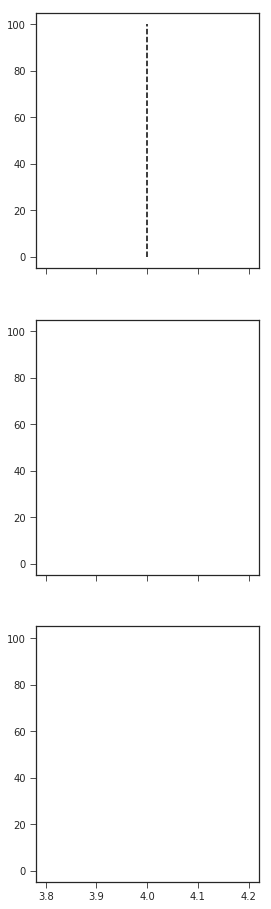

In [11]:
f, axs = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(4, 16))
betti_num = 3
stims = list(bc_tavg.keys())[1:4]
my = 0
nmaxyt = 0
nmaxxt = 0
for ax, stim in zip(axs.flatten(), bc_tavg.keys()):
    final_bettis = bc_tavg[stim][:, -1, 0]
   
    #final_bettis = stim_betticurve_dict[stim][-1]
    b = final_bettis[betti_num]
    ax.plot([b, b], [0, 100], 'k--')
    (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax, align='left', histtype='stepfilled')
    nmaxyt = np.amax([nmaxy, nmaxyt])
    nmaxxt = np.amax([nmaxx, nmaxxt])
    print(final_bettis)

    #ax.set_title(stim)
    
    ax.set_xlim([-0.1, 1.25*nmaxxt])
    ax.set_ylim([0, 1.25*nmaxyt])
    ax.tick_params(labelsize=20)
plt.savefig(os.path.join(figsavepth, 'SCMControl_betti{}.eps'.format(betti_num)))

144.0
[ 2. 58. 41.  3.  0.]
93.0
[ 3. 42. 42.  0.  0.]
102.0
[ 2. 73. 10.  1.  2.]
207.0
[ 2. 58. 41.  3.  0.]
318.0
[ 3. 42. 42.  0.  0.]
159.0
[ 2. 73. 10.  1.  2.]
124.0
[ 2. 56.  3.  0.  0.]
134.0
[ 1. 52.  4.  0.  0.]
105.0
[ 3. 47.  0.  0.  0.]
12.0
[ 2. 56.  3.  0.  0.]
14.0
[ 1. 52.  4.  0.  0.]
4.0
[ 3. 47.  0.  0.  0.]
72.0
[ 1. 23.  4.  0.  0.]
34.0
[ 1. 20. 12.  0.  0.]
60.0
[ 1. 37.  5.  1.  0.]
20.0
[ 1. 23.  4.  0.  0.]
68.0
[ 1. 20. 12.  0.  0.]
72.0
[ 1. 37.  5.  1.  0.]
51.0
[ 2. 22. 12.  2.  0.]
76.0
[ 1. 32.  1.  0.  0.]
69.0
[ 1. 26.  0.  0.  0.]
68.0
[ 2. 22. 12.  2.  0.]
3.0
[ 1. 32.  1.  0.  0.]
3.0
[ 1. 26.  0.  0.  0.]


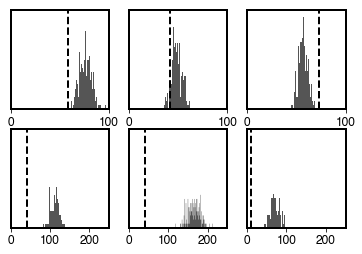

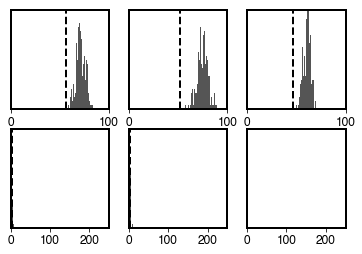

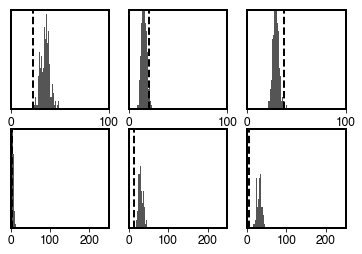

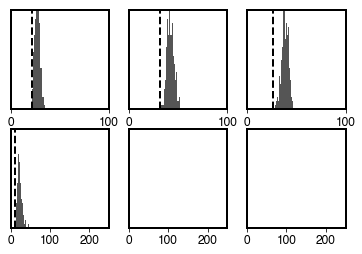

In [12]:
for bird in birds:
    bc_tavg = bc_tavg_store[bird]
    stim_scm_dict = bird_scm_dict[bird]
    f, axs = plt.subplots(2, 3,figsize=(6, 4), sharey=True, sharex=False)
    betti_num = 3
    bettis = [1,2]
    stims = list(bc_tavg.keys())[1:4]
    my = 0
    for ind, betti_num in enumerate(bettis):
        nmaxyt = 0
        nmaxxt = 0
        for stimind, stim in enumerate(stims):
            final_bettis = bc_tavg[stim][:, -1, 0]
            ax = axs[ind, stimind]
            #final_bettis = stim_betticurve_dict[stim][-1]
            b = final_bettis[betti_num]
            ax.plot([b, b], [0, 100], 'k--', linewidth=2)
            (nmaxy, nmaxx) = plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax=ax, align='left', histtype='stepfilled', color="#555555")
            nmaxyt = np.amax([nmaxy, nmaxyt])
            nmaxxt = np.amax([nmaxx, nmaxxt])
            print(final_bettis)

            if ind > 0:
                xmax = 250

                ax.set_xticks(np.arange(0, 300, 100))
            else:
                xmax = 100

            ax.set_xlim([-0.1, xmax])
            ax.set_ylim([0, 0.12])
            ax.tick_params(labelsize=12)
            ax.set_yticks([])
            for i in ax.get_xticklabels():
                i.set_fontname('helvetica')
            for i in ax.get_yticklabels():
                i.set_fontname('helvetica')
            for axis in ['top', 'bottom', 'left', 'right']:
                ax.spines[axis].set_linewidth(2)


            #ax.set_title(stim)
    plt.savefig(os.path.join(figsavepth, 'SCMControl{}_bettiAll2.eps'.format(bird)))

Text(0,0.5,'Amplitude')

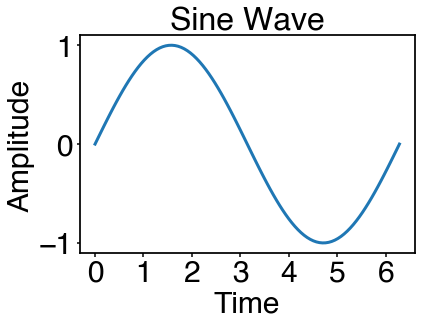

In [21]:
plt.style.use('/home/brad/code/NeuralTDA/bht.mplstyle')
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)
plt.plot(x, y)
plt.xticks([0, 1,2,3,4,5,6])
plt.title('Sine Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [ ]:
#compute pvalues
dims2 = [0,1,2]
for stim in bc_tavg.keys():
    for dim in dims2:
        final_betti = bc_tavg[stim][dim, -1, 0]
        scm_dist = np.array(stim_scm_dict[stim])
        scm_dist = [x[0][dim] for x in scm_dist]
        m = np.mean(scm_dist)
        N = len(scm_dist)
        if final_betti > m:
        
            count = np.sum(np.greater(scm_dist, final_betti))
        else:
            count = np.sum(np.less(scm_dist, final_betti))
        p = 2*(1+count)/(N+1)
        print('Stim: {} dim: {}  pvalue: {}'.format(stim, dim, p))
    print('\n')
    

In [ ]:
np.mean(stim_scm_dict[stim][:, :, 1])

In [ ]:
stim_scm_dict[stim]

In [ ]:
np.array(stim_scm_dict[stim]).shape

In [ ]:
test = stim_scm_dict[stim]


In [ ]:
test

In [ ]:
with h5.File(bdf, 'r') as f:
    test_pt = np.array(f[list(f.keys())[1]]['pop_tens'])

In [ ]:
test_pt.shape

In [ ]:
trialavg = np.mean(test_pt, axis=2)

In [ ]:
avg_frs = np.mean(trialavg, axis=1)

In [ ]:
avg_frs.shape

In [ ]:
avg_frs

# Calculate scm distrib at different points throught a single stimulus

In [46]:
# average over all trials
import tqdm
reload(tp2)
nsamples = 200
stim = 'L_40k'
ntimes = 10
stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}
with h5.File(bdf, 'r') as bdff:
    stims = bdff.keys()
    for timept in tqdm.tqdm(range(ntimes)):
        #print(stim)
        trial=0
        stim_poptens = tp2.extract_population_tensor(bdf, stim)
        t = int(np.linspace(0, tp2.num_win(stim_poptens), ntimes)[timept])
        ntrials = tp2.num_trials(stim_poptens)
        stim_scm_dat= []
        stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, 0:t, np.newaxis]     
        scm_bettis = tp2.calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
        stim_scm_dict[timept] = scm_bettis


  0%|          | 0/10 [00:00<?, ?it/s]/home/brad/code/NeuralTDA/neuraltda/simpComp.py:467: RuntimeWarning: invalid value encountered in true_divide
  means = popvec.sum(1)/Nwin

0it [00:00, ?it/s]
1it [00:00,  9.79it/s]
 10%|█         | 1/10 [00:00<00:01,  7.72it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None
Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [00:00,  2.41it/s]
14it [00:00,  3.42it/s]
27it [00:00,  4.83it/s]
40it [00:00,  6.79it/s]
53it [00:00,  9.48it/s]
65it [00:00, 13.08it/s]
77it [00:01, 17.78it/s]
88it [00:01, 23.73it/s]
100it [00:01, 31.17it/s]
113it [00:01, 40.29it/s]
127it [00:01, 50.85it/s]
140it [00:01, 61.65it/s]
154it [00:01, 73.11it/s]
167it [00:01, 83.79it/s]
180it [00:01, 92.68it/s]
193it [00:01, 100.02it/s]
 20%|██        | 2/10 [00:02<00:05,  1.41it/s]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [00:06,  6.82s/it]
11it [00:06,  4.77s/it]
21it [00:07,  3.35s/it]
31it [00:07,  2.34s/it]
41it [00:07,  1.64s/it]
51it [00:07,  1.15s/it]
61it [00:07,  1.23it/s]
71it [00:07,  1.75it/s]
81it [00:07,  2.48it/s]
91it [00:07,  3.51it/s]
101it [00:07,  4.93it/s]
111it [00:07,  6.88it/s]
121it [00:08,  9.53it/s]
131it [00:08, 13.04it/s]
141it [00:08, 17.59it/s]
151it [00:08, 23.11it/s]
161it [00:08, 29.85it/s]
171it [00:08, 37.45it/s]
181it [00:08, 45.58it/s]
191it [00:08, 49.61it/s]
200it [00:09, 48.11it/s]
 30%|███       | 3/10 [00:11<00:22,  3.23s/it]
0it [00:00, ?it/s]

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [00:13, 13.37s/it]
6it [00:13,  9.37s/it]
11it [00:13,  6.56s/it]
16it [00:13,  4.60s/it]
21it [00:13,  3.23s/it]
25it [00:13,  2.27s/it]
30it [00:14,  1.59s/it]
35it [00:14,  1.12s/it]
40it [00:14,  1.26it/s]
45it [00:14,  1.79it/s]
50it [00:14,  2.51it/s]
55it [00:14,  3.51it/s]
60it [00:14,  4.86it/s]
65it [00:14,  6.65it/s]
70it [00:14,  8.96it/s]
75it [00:14, 11.86it/s]
80it [00:15, 15.26it/s]
85it [00:15, 19.18it/s]
90it [00:15, 23.42it/s]
95it [00:15, 27.86it/s]
100it [00:15, 31.93it/s]
105it [00:15, 35.31it/s]
110it [00:15, 38.47it/s]
115it [00:15, 41.16it/s]
120it [00:15, 43.22it/s]
125it [00:15, 44.42it/s]
130it [00:16, 45.02it/s]
135it [00:16, 46.26it/s]
140it [00:16, 47.15it/s]
146it [00:16, 48.01it/s]
151it [00:16, 47.39it/s]
156it [00:16, 47.87it/s]
161it [00:16, 47.72it/s]
166it [00:16, 48.24it/s]
171it [00:16, 48.29it/s]
176it [00:17, 48.31it/s]
181it [00:17, 48.68it/s]
186it [00:17, 48.99it/s]
191it [00:17, 48.78it/s]
196it [00:17, 49.11it/s]
 40%|████      | 4/10

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [00:27, 27.36s/it]
6it [00:27, 19.16s/it]
11it [00:27, 13.42s/it]
16it [00:27,  9.40s/it]
20it [00:27,  6.59s/it]
25it [00:27,  4.62s/it]
30it [00:28,  3.24s/it]
34it [00:28,  2.28s/it]
39it [00:28,  1.60s/it]
43it [00:28,  1.13s/it]
48it [00:28,  1.26it/s]
52it [00:28,  1.77it/s]
57it [00:28,  2.48it/s]
61it [00:28,  3.45it/s]
66it [00:28,  4.76it/s]
71it [00:29,  6.47it/s]
76it [00:29,  8.65it/s]
81it [00:29, 11.34it/s]
86it [00:29, 14.48it/s]
91it [00:29, 17.98it/s]
96it [00:29, 21.55it/s]
101it [00:29, 25.01it/s]
106it [00:29, 28.23it/s]
111it [00:30, 30.85it/s]
116it [00:30, 33.02it/s]
120it [00:30, 34.75it/s]
124it [00:30, 35.98it/s]
129it [00:30, 37.46it/s]
134it [00:30, 38.33it/s]
139it [00:30, 39.17it/s]
144it [00:30, 39.76it/s]
149it [00:31, 39.92it/s]
154it [00:31, 40.16it/s]
159it [00:31, 40.33it/s]
164it [00:31, 40.09it/s]
169it [00:31, 40.01it/s]
174it [00:31, 39.87it/s]
178it [00:31, 39.72it/s]
182it [00:31, 39.80it/s]
186it [00:31, 39.63it/s]
191it [00:32, 39.77it/

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [01:00, 60.81s/it]
4it [01:00, 42.58s/it]
7it [01:01, 29.82s/it]
10it [01:01, 20.89s/it]
13it [01:01, 14.63s/it]
16it [01:01, 10.25s/it]
19it [01:01,  7.19s/it]
22it [01:01,  5.05s/it]
25it [01:01,  3.54s/it]
28it [01:01,  2.49s/it]
31it [01:02,  1.76s/it]
34it [01:02,  1.24s/it]
37it [01:02,  1.14it/s]
40it [01:02,  1.59it/s]
43it [01:02,  2.21it/s]
46it [01:02,  3.04it/s]
49it [01:02,  4.14it/s]
52it [01:02,  5.52it/s]
55it [01:02,  7.21it/s]
58it [01:03,  9.18it/s]
61it [01:03, 11.37it/s]
64it [01:03, 13.69it/s]
67it [01:03, 15.94it/s]
70it [01:03, 18.01it/s]
73it [01:03, 19.56it/s]
76it [01:03, 20.74it/s]
79it [01:03, 21.94it/s]
82it [01:04, 22.66it/s]
85it [01:04, 23.20it/s]
88it [01:04, 23.83it/s]
91it [01:04, 24.44it/s]
94it [01:04, 24.67it/s]
97it [01:04, 25.03it/s]
100it [01:04, 25.25it/s]
103it [01:04, 25.31it/s]
106it [01:04, 25.29it/s]
109it [01:05, 25.70it/s]
112it [01:05, 23.76it/s]
115it [01:05, 24.19it/s]
118it [01:05, 24.32it/s]
121it [01:05, 24.96it/s]
124it [01:

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [01:48, 108.42s/it]
2it [01:48, 75.94s/it] 
3it [01:48, 53.20s/it]
4it [01:48, 37.29s/it]
5it [01:49, 26.15s/it]
6it [01:49, 18.36s/it]
7it [01:49, 12.90s/it]
8it [01:49,  9.07s/it]
9it [01:49,  6.39s/it]
10it [01:49,  4.52s/it]
11it [01:49,  3.21s/it]
12it [01:50,  2.29s/it]
13it [01:50,  1.65s/it]
14it [01:50,  1.20s/it]
15it [01:50,  1.13it/s]
16it [01:50,  1.52it/s]
17it [01:50,  1.98it/s]
18it [01:50,  2.53it/s]
19it [01:51,  3.12it/s]
20it [01:51,  3.75it/s]
21it [01:51,  4.32it/s]
22it [01:51,  4.82it/s]
23it [01:51,  5.27it/s]
24it [01:51,  5.61it/s]
25it [01:52,  5.91it/s]
26it [01:52,  6.07it/s]
27it [01:52,  6.28it/s]
28it [01:52,  6.25it/s]
29it [01:52,  6.37it/s]
30it [01:52,  6.48it/s]
31it [01:52,  6.46it/s]
32it [01:53,  6.48it/s]
33it [01:53,  6.53it/s]
34it [01:53,  6.30it/s]
35it [01:53,  6.29it/s]
36it [01:53,  6.51it/s]
37it [01:53,  6.43it/s]
38it [01:54,  6.31it/s]
39it [01:54,  6.39it/s]
40it [01:54,  6.43it/s]
41it [01:54,  6.31it/s]
42it [01:54,  6.37it/s

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [01:45, 105.14s/it]
2it [01:45, 73.63s/it] 
3it [01:45, 51.59s/it]
4it [01:45, 36.16s/it]
5it [01:45, 25.35s/it]
6it [01:45, 17.78s/it]
7it [01:45, 12.49s/it]
8it [01:46,  8.78s/it]
9it [01:46,  6.19s/it]
10it [01:46,  4.37s/it]
11it [01:46,  3.10s/it]
12it [01:46,  2.21s/it]
13it [01:46,  1.59s/it]
14it [01:46,  1.16s/it]
15it [01:47,  1.18it/s]
16it [01:47,  1.56it/s]
17it [01:47,  2.04it/s]
18it [01:47,  2.61it/s]
19it [01:47,  3.26it/s]
20it [01:47,  3.93it/s]
21it [01:47,  4.57it/s]
22it [01:48,  5.19it/s]
23it [01:48,  5.79it/s]
24it [01:48,  6.18it/s]
25it [01:48,  6.34it/s]
26it [01:48,  6.57it/s]
27it [01:48,  6.71it/s]
28it [01:48,  6.82it/s]
29it [01:48,  7.08it/s]
30it [01:49,  7.21it/s]
31it [01:49,  7.37it/s]
32it [01:49,  7.28it/s]
33it [01:49,  7.39it/s]
34it [01:49,  7.29it/s]
35it [01:49,  7.16it/s]
36it [01:49,  7.37it/s]
37it [01:50,  7.32it/s]
38it [01:50,  7.36it/s]
39it [01:50,  7.39it/s]
40it [01:50,  7.39it/s]
41it [01:50,  7.36it/s]
42it [01:50,  7.19it/s

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [03:04, 184.78s/it]
2it [03:05, 129.42s/it]
3it [03:05, 90.66s/it] 
4it [03:05, 63.54s/it]
5it [03:05, 44.56s/it]
6it [03:06, 31.28s/it]
7it [03:06, 21.97s/it]
8it [03:06, 15.45s/it]
9it [03:06, 10.88s/it]
10it [03:07,  7.69s/it]
11it [03:07,  5.46s/it]
12it [03:07,  3.90s/it]
13it [03:07,  2.80s/it]
14it [03:07,  2.03s/it]
15it [03:08,  1.50s/it]
16it [03:08,  1.13s/it]
17it [03:08,  1.16it/s]
18it [03:09,  1.44it/s]
19it [03:09,  1.78it/s]
20it [03:09,  2.12it/s]
21it [03:09,  2.50it/s]
22it [03:10,  2.78it/s]
23it [03:10,  3.11it/s]
24it [03:10,  3.39it/s]
25it [03:10,  3.61it/s]
26it [03:11,  3.76it/s]
27it [03:11,  3.86it/s]
28it [03:11,  3.90it/s]
29it [03:11,  4.01it/s]
30it [03:12,  3.97it/s]
31it [03:12,  3.94it/s]
32it [03:12,  3.96it/s]
33it [03:12,  4.01it/s]
34it [03:13,  3.85it/s]
35it [03:13,  3.97it/s]
36it [03:13,  3.90it/s]
37it [03:13,  4.01it/s]
38it [03:14,  3.93it/s]
39it [03:14,  3.99it/s]
40it [03:14,  4.03it/s]
41it [03:14,  3.98it/s]
42it [03:15,  3.87it/

Extracting Population Activity Tensor...
Stim: L_40k, Clusters:None



1it [04:21, 261.41s/it]
2it [04:21, 183.07s/it]
3it [04:22, 128.25s/it]
4it [04:22, 89.87s/it] 
5it [04:22, 63.00s/it]
6it [04:22, 44.19s/it]
7it [04:23, 31.01s/it]
8it [04:23, 21.81s/it]
9it [04:23, 15.35s/it]
10it [04:24, 10.84s/it]
11it [04:24,  7.67s/it]
12it [04:24,  5.46s/it]
13it [04:25,  3.92s/it]
14it [04:25,  2.83s/it]
15it [04:25,  2.08s/it]
16it [04:25,  1.54s/it]
17it [04:26,  1.17s/it]
18it [04:26,  1.10it/s]
19it [04:26,  1.38it/s]
20it [04:27,  1.64it/s]
21it [04:27,  1.95it/s]
22it [04:27,  2.20it/s]
23it [04:28,  2.47it/s]
24it [04:28,  2.64it/s]
25it [04:28,  2.81it/s]
26it [04:29,  2.93it/s]
27it [04:29,  3.04it/s]
28it [04:29,  3.15it/s]
29it [04:29,  3.20it/s]
30it [04:30,  3.24it/s]
31it [04:30,  3.24it/s]
32it [04:30,  3.19it/s]
33it [04:31,  3.26it/s]
34it [04:31,  3.25it/s]
35it [04:31,  3.28it/s]
36it [04:32,  3.32it/s]
37it [04:32,  3.33it/s]
38it [04:32,  3.38it/s]
39it [04:32,  3.40it/s]
40it [04:33,  3.32it/s]
41it [04:33,  3.38it/s]
42it [04:33,  3.34it

In [47]:
import pickle
with open(os.path.join(block_path,'scm_control_save_trialvg_thresh13_stimL_10timepts.pkl'), 'wb') as f:
    pickle.dump(stim_scm_dict, f)

In [8]:
with open(os.path.join(block_path,'scm_control_save_trialvg_thresh13_stimL_10timepts.pkl'), 'rb') as f:
    stim_scm_dict = pickle.load(f)
    print(stim_scm_dict.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


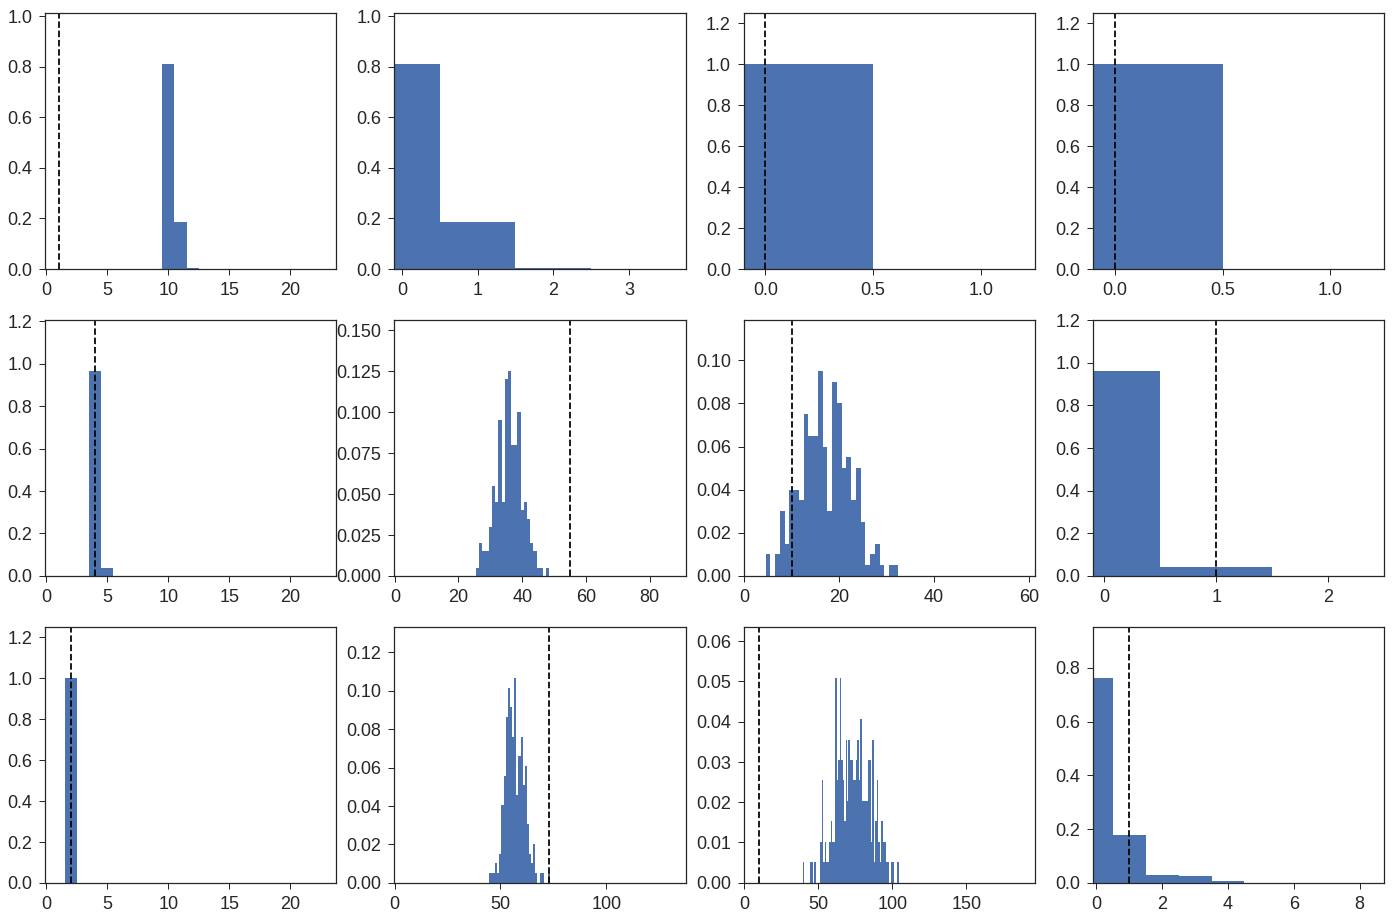

In [9]:
times_plot = [1,5,9]
ntimes_plot = len(times_plot)

f, axs = plt.subplots(ntimes_plot, 4,figsize=(24, 16))
bettis = [0,1,2,3]
stim = 'L_40k'

for betti_num in bettis:
    nmaxyt = 0
    nmaxxt = 0
    bettiax = axs.flatten()[4*(np.arange(ntimes_plot)) + betti_num]
    for ax, t in zip(bettiax, times_plot):
        bettivals = bc_tavg[stim][:, t, 0]
   
        b = bettivals[betti_num]
        ax.plot([b, b], [0, 100], 'k--')
        (nmaxy, nmaxx) = plot_scm_distrib(stim_scm_dict[t], betti_num, ax=ax, align='left', histtype='stepfilled')
        nmaxyt = np.amax([nmaxy, nmaxyt])
        nmaxyt = nmaxy
        nmaxxt = np.amax([nmaxx, nmaxxt])
        ax.set_xlim([-0.1, 1.25*nmaxxt])
        ax.set_ylim([0, 1.25*nmaxyt])
        ax.tick_params(labelsize=18)
plt.savefig(os.path.join(figsavepth, 'SCMControlB1083_betti_stimL_10timepts.eps'.format(betti_num)))

In [16]:
stim_scm_dict.keys()

dict_keys([])

In [61]:
stim_scm_dict[6][:, 0, 2]

array([ 27.,  30.,  20.,  34.,  29.,  23.,  32.,  34.,  33.,  34.,  27.,
        27.,  27.,  25.,  28.,  31.,  21.,  35.,  30.,  23.,  32.,  39.,
        34.,  30.,  35.,  34.,  38.,  47.,  51.,  40.,  27.,  20.,  24.,
        -1.,  36.,  30.,  24.,  -1.,  34.,  34.,  19.,  32.,  35.,  28.,
        26.,  36.,  13.,  17.,  24.,  31.,  32.,  23.,  30.,  25.,  38.,
        28.,  29.,  33.,  27.,  28.,  27.,  30.,  32.,  38.,  42.,  26.,
        35.,  32.,  21.,  27.,  39.,  32.,  -1.,  27.,  35.,  25.,  33.,
        35.,  26.,  39.,  33.,  30.,  32.,  25.,  34.,  33.,  29.,  27.,
        29.,  39.,  20.,  21.,  27.,  20.,  29.,  24.,  21.,  19.,  21.,
        36.,  32.,  19.,  23.,  22.,  21.,  -1.,  22.,  26.,  19.,  22.,
        31.,  34.,  46.,  29.,  34.,  29.,  17.,  43.,  29.,  29.,  28.,
        38.,  37.,  30.,  25.,  26.,  28.,  22.,  37.,  28.,  19.,  21.,
        38.,  34.,  31.,  31.,  28.,  25.,  19.,  18.,  22.,  31.,  23.,
        29.,  47.,  27.,  19.,  26.,  37.,  27.,  3